## 1. Import các thư viện cần thiết

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

TensorFlow version: 2.19.0
GPU available: []


## 2. Cấu hình và đường dẫn dữ liệu

In [ ]:
# Cấu hình
IMAGE_SIZE = (224, 224)  
BATCH_SIZE = 32 
EPOCHS = 30  
FRAMES_PER_VIDEO = 15  
RANDOM_STATE = 42
MODEL_PATH = 'cnn1.h5'

# Đường dẫn dữ liệu
dataset_path = "anti-spoofing_data"  
csv_path = os.path.join(dataset_path, "anti-spoofing.csv")

# Kiểm tra đường dẫn
print(f"Dataset path exists: {os.path.exists(dataset_path)}")
if os.path.exists(dataset_path):
    print(f"Contents: {os.listdir(dataset_path)}")

Dataset path exists: True
Contents: ['anti-spoofing.csv', 'cut-out printouts', 'live_selfie', 'live_video', 'printouts', 'replay']


## 3. Định nghĩa các hàm xử lý dữ liệu

In [ ]:
def preprocess_image(image):
    # Chuyển đổi không gian màu từ BGR sang RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Chuẩn hóa ảnh
    image = image / 255.0
    
    return image

In [ ]:
def load_data(dataset_path, categories, img_size=IMAGE_SIZE, frames_per_video=FRAMES_PER_VIDEO):
    data = []
    labels = []
    binary_labels = []  # Nhãn nhị phân: 0 = real, 1 = fake
    file_paths = []  

    real_categories = ["live_selfie", "live_video"]
    fake_categories = ["cut-out printouts", "printouts", "replay"]
    
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        label = categories.index(category)
        binary_label = 0 if category in real_categories else 1 
        
        # Kiểm tra thư mục tồn tại
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist. Skipping...")
            continue
            
        for video_file in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_file)
            file_paths.append(video_path)
            
            try:
                cap = cv2.VideoCapture(video_path)
                if not cap.isOpened():
                    print(f"Warning: Could not open video {video_path}. Skipping...")
                    continue
                    
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                if frame_count == 0:
                    print(f"Warning: Video {video_path} has 0 frames. Skipping...")
                    continue
                    
                # Chọn frames đều đặn từ video
                selected_frames = np.linspace(0, frame_count - 1, min(frames_per_video, frame_count)).astype(int)
                
                for frame_num in selected_frames:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
                    ret, frame = cap.read()
                    
                    if ret:
                        # Resize và tiền xử lý ảnh
                        frame = cv2.resize(frame, img_size)
                        frame = preprocess_image(frame)
                        
                        data.append(frame)
                        labels.append(label)
                        binary_labels.append(binary_label)
                    else:
                        print(f"Warning: Could not read frame {frame_num} from {video_path}")
                        
                cap.release()
            except Exception as e:
                print(f"Error processing {video_path}: {str(e)}")
    
    return np.array(data), np.array(labels), np.array(binary_labels), file_paths

In [5]:
# Hàm tạo data augmentation
def create_data_generator():
    return ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

## 4. Tải và chuẩn bị dữ liệu

In [ ]:
categories = ["live_selfie", "live_video", "cut-out printouts", "printouts", "replay"]
print(f"Categories: {categories}")

print("Loading data...")

Categories: ['live_selfie', 'live_video', 'cut-out printouts', 'printouts', 'replay']
Loading data...


Loaded 547 images with shapes (547, 224, 224, 3)
Class distribution: [  9 135 134 135 134]
Binary class distribution: [144 403]


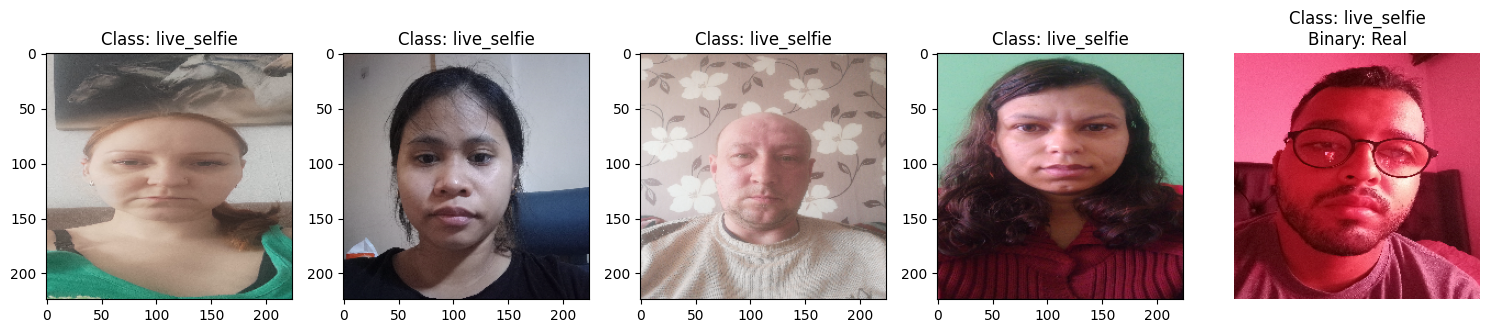

In [7]:
X, y, binary_y, file_paths = load_data(dataset_path, categories)

print(f"Loaded {len(X)} images with shapes {X.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Binary class distribution: {np.bincount(binary_y)}")

# Hiển thị một số ảnh mẫu
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i])
    plt.title(f"Class: {categories[y[i]]}")
plt.title(f"Class: {categories[y[i]]}\nBinary: {'Real' if binary_y[i] == 0 else 'Fake'}")
plt.axis('off')
plt.tight_layout()
plt.show()


Training set: (437, 224, 224, 3), (437,)
Testing set: (110, 224, 224, 3), (110,)


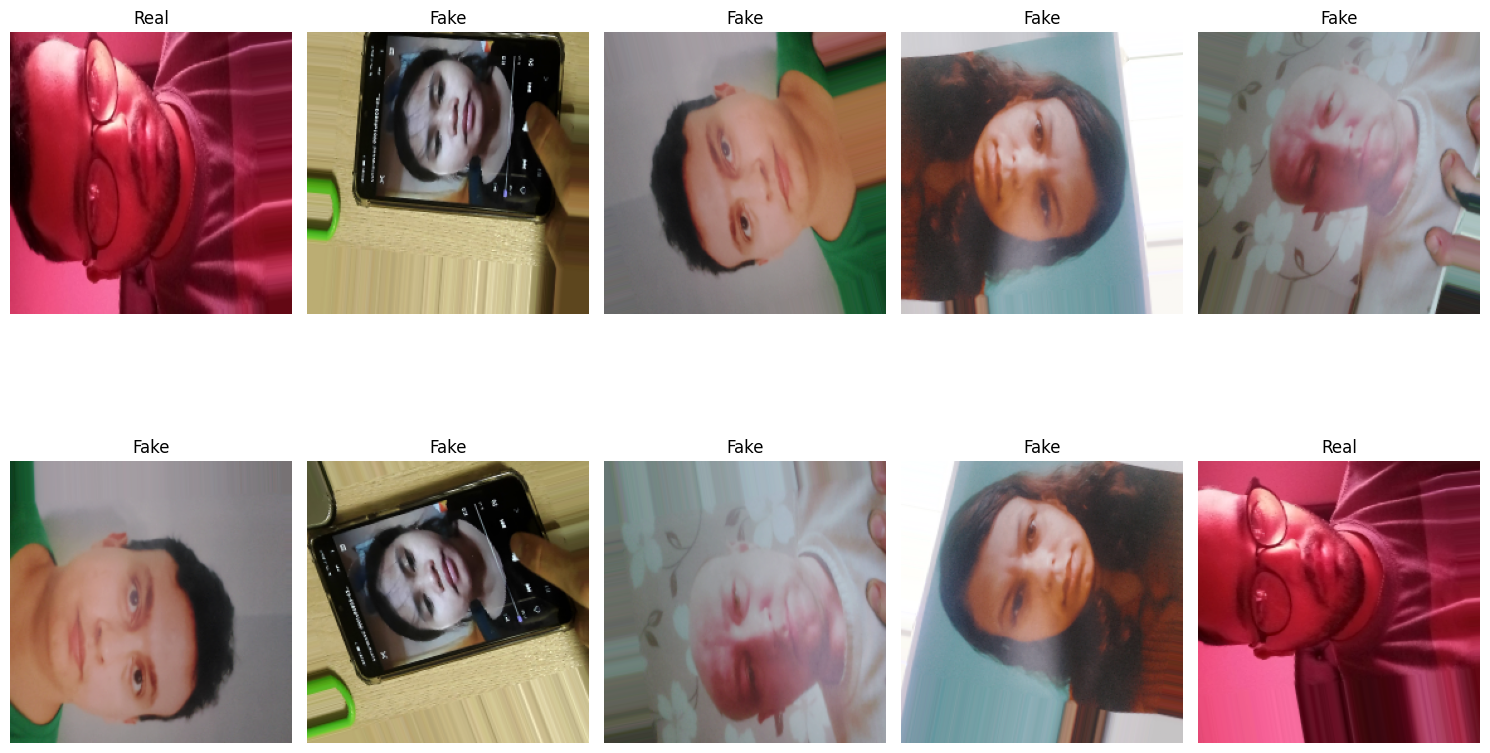

In [8]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test, binary_y_train, binary_y_test = train_test_split(
    X, y, binary_y, test_size=0.2, stratify=binary_y, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape}, {binary_y_train.shape}")
print(f"Testing set: {X_test.shape}, {binary_y_test.shape}")

# Reshape binary_y_train và binary_y_test
binary_y_train = np.array(binary_y_train).reshape(-1, 1)
binary_y_test = np.array(binary_y_test).reshape(-1, 1)

# Tạo data generator cho augmentation
datagen = create_data_generator()
datagen.fit(X_train)

# Hiển thị một số ảnh đã augment
plt.figure(figsize=(15, 10))
for i, (image, label) in enumerate(datagen.flow(X_train[:5], binary_y_train[:5], batch_size=5)):
    for j in range(5):
        plt.subplot(2, 5, i*5 + j + 1)
        plt.imshow(image[j])
        plt.title(f"{'Real' if label[j] == 0 else 'Fake'}")
        plt.axis('off')
    if i >= 1:
        break
plt.tight_layout()
plt.show()


## 5. Xây dựng mô hình CNN cải tiến

In [ ]:
def create_model(input_shape):
    # Sử dụng transfer learning với MobileNetV2
    # Lý do chọn MobileNetV2: nhẹ, hiệu quả, phù hợp cho ứng dụng real-time
    base_model = applications.MobileNetV2(
        weights='imagenet',  # Sử dụng pre-trained weights
        include_top=False,   # Bỏ classifier layers cuối
        input_shape=input_shape
    )
    
    # Đóng băng base model để giữ nguyên feature extraction
    base_model.trainable = False
    
    # Xây dựng classifier layers
    model = keras.Sequential([
        base_model,
        
        # Chuyển từ feature maps sang vector đặc trưng
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        
        # First dense layer: học các pattern phức tạp
        layers.Dense(256, activation='relu', name='dense_256'),
        layers.Dropout(0.5),  # Ngăn overfitting
        layers.BatchNormalization(),
        
        # Second dense layer: tinh chỉnh các đặc trưng
        layers.Dense(128, activation='relu', name='dense_128'),
        layers.Dropout(0.3),  # Dropout thấp hơn ở layer gần output
        layers.BatchNormalization(),
        
        # Output layer: 1 neuron với sigmoid cho binary classification
        # Sigmoid output range [0,1]: gần 0 = Real, gần 1 = Fake
        layers.Dense(1, activation='sigmoid', name='binary_output')
    ], name='AntiSpoofing_Binary_Model')
    
    # Compile với cấu hình tối ưu cho binary classification
    optimizer = keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  
        metrics=['accuracy', 'precision', 'recall']  # Metrics quan trọng cho anti-spoofing
    )
    
    return model

In [10]:
print("Creating model...")
model = create_model(input_shape=(*IMAGE_SIZE, 3))
model.summary()

Creating model...


Model: "AntiSpoofing_Binary_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224         │ (None, 7, 7, 1280)    │    2,257,984 │
│ (Functional)                 │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ global_average_pooling2d     │ (None, 1280)          │            0 │
│ (GlobalAveragePooling2D)     │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization          │ (None, 1280)          │        5,120 │
│ (BatchNormalization)         │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_256 (Dense)            │ (None, 256)           │      327,936 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)            │ (None, 256)           │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_1        │ (None, 256)           │        1,024 │
│ (BatchNormalization)         │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_128 (Dense)            │ (None, 128)           │       32,896 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_1 (Dropout)          │ (None, 128)           │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ batch_normalization_2        │ (None, 128)           │          512 │
│ (BatchNormalization)         │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ binary_output (Dense)        │ (None, 1)             │          129 │
└──────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 2,625,601 (10.02 MB)

 Trainable params: 364,289 (1.39 MB)

 Non-trainable params: 2,261,312 (8.63 MB)

## 6. Huấn luyện mô hình

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Chuẩn bị dữ liệu training - QUAN TRỌNG
# Flatten binary_y để có shape phù hợp
binary_y_train_flat = binary_y_train.flatten()  # Chuyển từ (n, 1) thành (n,)
binary_y_test_flat = binary_y_test.flatten()    # Chuyển từ (n, 1) thành (n,)

print(f"Training labels shape: {binary_y_train_flat.shape}")
print(f"Testing labels shape: {binary_y_test_flat.shape}")

print("Training model...")
history = model.fit(
    datagen.flow(X_train, binary_y_train_flat, batch_size=BATCH_SIZE),
    validation_data=(X_test, binary_y_test_flat),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Training labels shape: (437,)
Testing labels shape: (110,)
Training model...


C:\Users\md111\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6013 - loss: 0.7243 - precision: 0.8206 - recall: 0.5570
Epoch 1: val_accuracy improved from -inf to 0.83636, saving model to anti_spoofing_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 772ms/step - accuracy: 0.6051 - loss: 0.7194 - precision: 0.8251 - recall: 0.5608 - val_accuracy: 0.8364 - val_loss: 0.3048 - val_precision: 0.8247 - val_recall: 0.9877 - learning_rate: 0.0010
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7887 - loss: 0.4665 - precision: 0.9825 - recall: 0.7292
Epoch 2: val_accuracy improved from 0.83636 to 0.94545, saving model to anti_spoofing_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 616ms/step - accuracy: 0.7904 - loss: 0.4644 - precision: 0.9821 - recall: 0.7317 - val_accuracy: 0.9455 - val_loss: 0.2170 - val_precision: 0.9630 - val_recall: 0.9630 - learning_rate: 0.0010
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8974 - loss: 0.2861 - precision: 0.9696 - recall: 0.8849
Epoch 3: val_accuracy improved from 0.94545 to 0.95455, saving model to anti_spoofing_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 631ms/step - accuracy: 0.8974 - loss: 0.2858 - precision: 0.9703 - recall: 0.8845 - val_accuracy: 0.9545 - val_loss: 0.2019 - val_precision: 0.9750 - val_recall: 0.9630 - learning_rate: 0.0010
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.8632 - loss: 0.3320 - precision: 0.9863 - recall: 0.8344
Epoch 4: val_accuracy did not improve from 0.95455
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 593ms/step - accuracy: 0.8658 - loss: 0.3284 - precision: 0.9863 - recall: 0.8374 - val_accuracy: 0.9545 - val_loss: 0.1611 - val_precision: 0.9750 - val_recall: 0.9630 - learning_rate: 0.0010
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9006 - loss: 0.2249 - precision: 0.9660 - recall: 0.8934
Epoch 5: val_accuracy improved from 0.95455 to 0.97273, saving model to anti_spoofing_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 616ms/step - accuracy: 0.9017 - loss: 0.2239 - precision: 0.9668 - recall: 0.8945 - val_accuracy: 0.9727 - val_loss: 0.1231 - val_precision: 0.9875 - val_recall: 0.9753 - learning_rate: 0.0010
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9120 - loss: 0.2303 - precision: 0.9849 - recall: 0.8957
Epoch 6: val_accuracy did not improve from 0.97273
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 704ms/step - accuracy: 0.9128 - loss: 0.2291 - precision: 0.9848 - recall: 0.8968 - val_accuracy: 0.9727 - val_loss: 0.1011 - val_precision: 1.0000 - val_recall: 0.9630 - learning_rate: 0.0010
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9374 - loss: 0.1561 - precision: 0.9667 - recall: 0.9476
Epoch 7: val_accuracy improved from 0.97273 to 0.98182, saving model to anti_spoofing_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 690ms/step - accuracy: 0.9376 - loss: 0.1574 - precision: 0.9680 - recall: 0.9465 - val_accuracy: 0.9818 - val_loss: 0.0993 - val_precision: 1.0000 - val_recall: 0.9753 - learning_rate: 0.0010
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9534 - loss: 0.1737 - precision: 0.9859 - recall: 0.9545
Epoch 8: val_accuracy did not improve from 0.98182
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 661ms/step - accuracy: 0.9540 - loss: 0.1716 - precision: 0.9858 - recall: 0.9551 - val_accuracy: 0.9818 - val_loss: 0.0948 - val_precision: 1.0000 - val_recall: 0.9753 - learning_rate: 0.0010
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9752 - loss: 0.0977 - precision: 0.9970 - recall: 0.9697
Epoch 9: val_accuracy did not improve from 0.98182
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 673ms/step - accuracy: 0.9754 - loss: 0.0970 - precision: 0.9970 - recall: 0.9700 - val_accuracy: 0.9818 - val_loss: 0.0873 - val_precision: 1.0000 - val_recall: 0.9753 - learn

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 711ms/step - accuracy: 0.9875 - loss: 0.0521 - precision: 0.9910 - recall: 0.9921 - val_accuracy: 0.9909 - val_loss: 0.0535 - val_precision: 1.0000 - val_recall: 0.9877 - learning_rate: 0.0010
Epoch 16/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9889 - loss: 0.0464 - precision: 0.9869 - recall: 0.9981
Epoch 16: val_accuracy did not improve from 0.99091
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 711ms/step - accuracy: 0.9886 - loss: 0.0468 - precision: 0.9868 - recall: 0.9978 - val_accuracy: 0.9818 - val_loss: 0.0655 - val_precision: 1.0000 - val_recall: 0.9753 - learning_rate: 0.0010
Epoch 17/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9872 - loss: 0.0523 - precision: 0.9948 - recall: 0.9877
Epoch 17: val_accuracy did not improve from 0.99091
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 722ms/step - accuracy: 0.9867 - loss: 0.0530 - precision: 0.9947 - recall: 0.9870 - val_accuracy: 0.9909 - val_loss: 0.0611 - val_precision: 1.0000 - val_recall: 0.9877 

## 7. Đánh giá mô hình

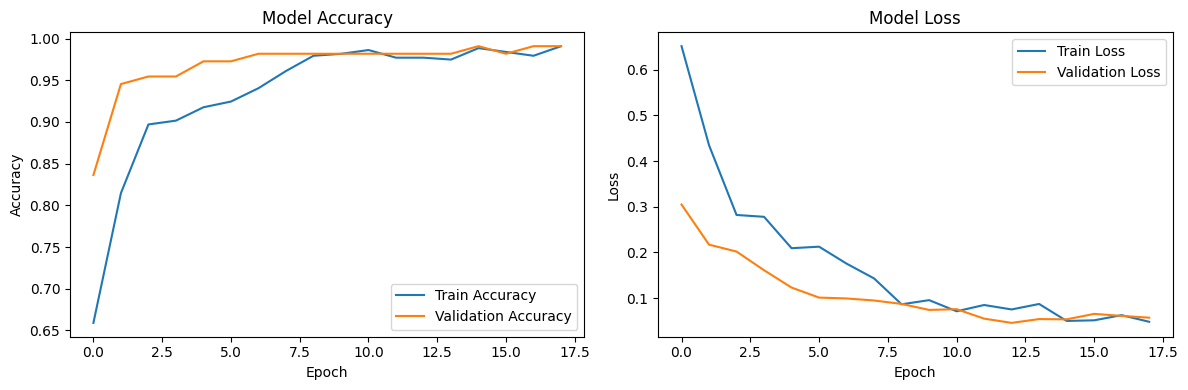

In [12]:
# Hàm vẽ biểu đồ kết quả huấn luyện
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Vẽ biểu đồ kết quả huấn luyện
plot_training_history(history)


In [13]:
# Đánh giá mô hình
print("Evaluating model...")
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # Cho phân loại nhị phân

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(binary_y_test, y_pred, target_names=['Real', 'Fake']))


Evaluating model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 719ms/step
Classification Report:
              precision    recall  f1-score   support

        Real       0.94      1.00      0.97        29
        Fake       1.00      0.98      0.99        81

    accuracy                           0.98       110
   macro avg       0.97      0.99      0.98       110
weighted avg       0.98      0.98      0.98       110



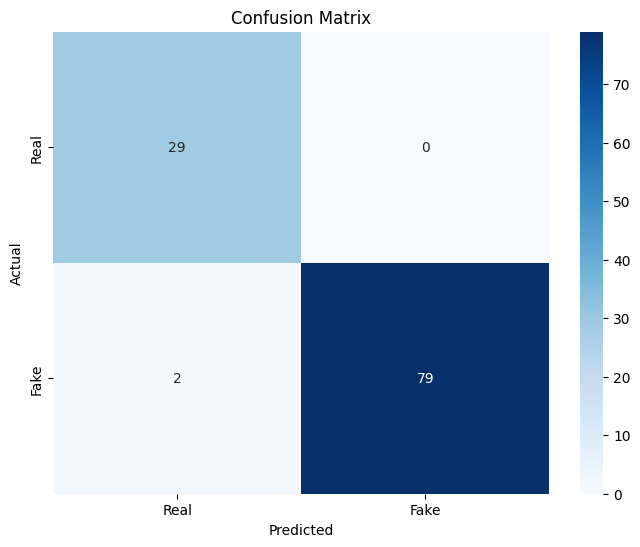

In [ ]:
# Hàm vẽ confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

# Vẽ confusion matrix
plot_confusion_matrix(binary_y_test, y_pred, ['Real', 'Fake'])


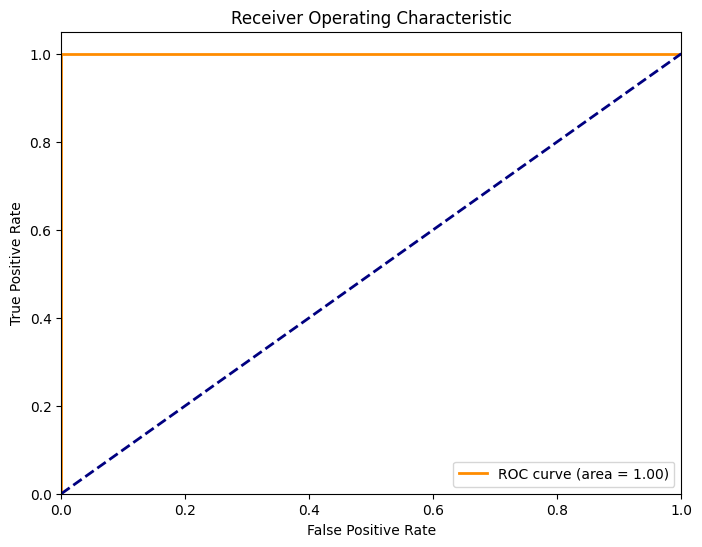

ROC AUC: 1.0000


In [15]:
# Hàm vẽ ROC curve (cho phân loại nhị phân)
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig('roc_curve.png')
    plt.show()
    
    return roc_auc

# Vẽ ROC curve
roc_auc = plot_roc_curve(binary_y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")


## 8. Lưu và tải mô hình

In [16]:
# Lưu mô hình (đã được lưu tự động bởi ModelCheckpoint)
print(f"Model saved to {MODEL_PATH}")

# Tải mô hình
loaded_model = keras.models.load_model(MODEL_PATH)
print("Model loaded successfully")


Model saved to anti_spoofing_model.h5


Model loaded successfully


## 9. Hàm dự đoán cho ảnh mới

In [17]:
# Hàm dự đoán cho ảnh mới
def predict_image(image_path, model_path=MODEL_PATH):
    # Tải mô hình đã huấn luyện
    model = keras.models.load_model(model_path)
    
    # Đọc và tiền xử lý ảnh
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMAGE_SIZE)
    image = preprocess_image(image)
    
    # Dự đoán
    prediction = model.predict(np.expand_dims(image, axis=0))[0][0]
    
    # Kết quả
    result = 'Fake' if prediction > 0.5 else 'Real'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    print(f"Image: {image_path}")
    print(f"Prediction: {result} (confidence: {confidence:.2f})")
    
    # Hiển thị ảnh và kết quả
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {result} Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()
    
    return result, confidence


## 10. Thử nghiệm dự đoán

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


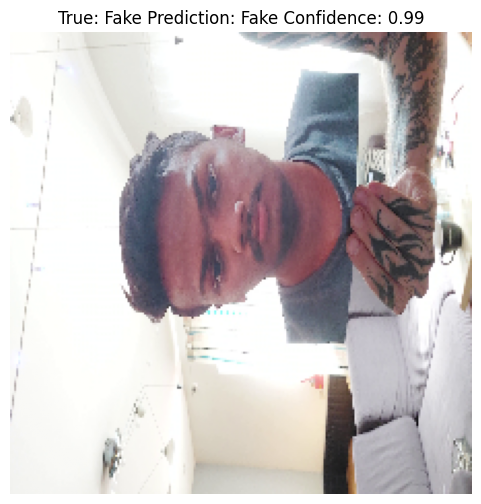

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


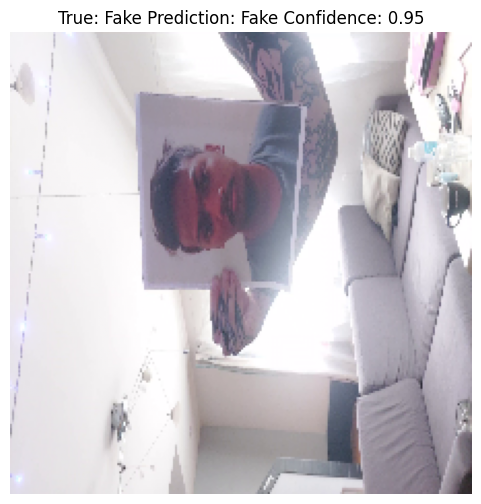

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


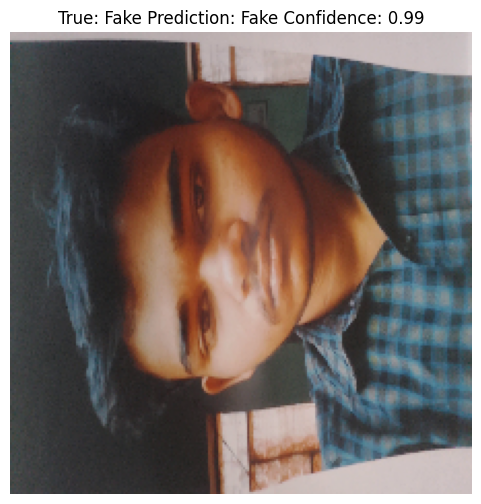

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


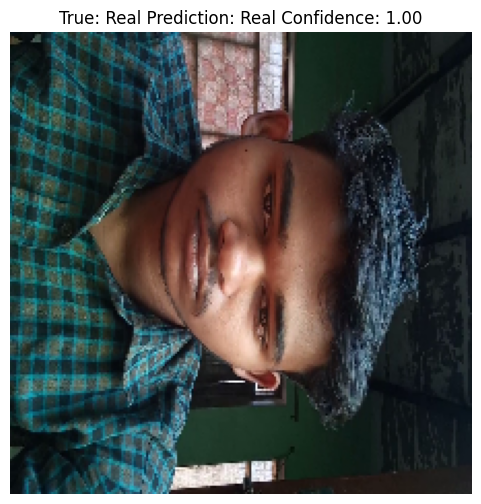

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


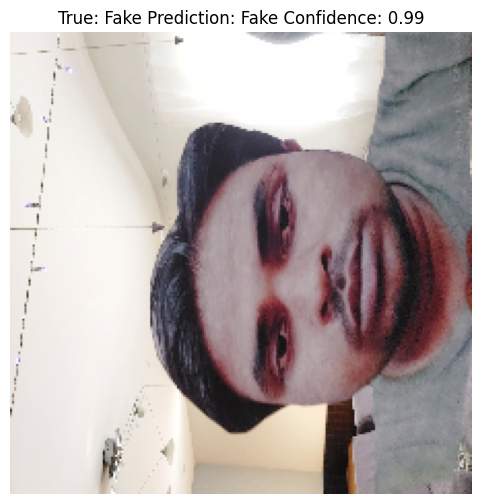

In [18]:
# Thử nghiệm dự đoán với một số ảnh từ tập test
test_indices = np.random.choice(len(X_test), 5, replace=False)

for idx in test_indices:
    # Lấy ảnh từ tập test
    image = X_test[idx]
    true_label = 'Real' if binary_y_test[idx] == 0 else 'Fake'
    
    # Dự đoán
    prediction = model.predict(np.expand_dims(image, axis=0))[0][0]
    pred_label = 'Fake' if prediction > 0.5 else 'Real'
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    # Hiển thị kết quả
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"True: {true_label} Prediction: {pred_label} Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()
